# Calculate velocity map errors over stable surfaces and extract velocities (centerline, glacier zone)

Run after geogrid/autoRIFT

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import shutil

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.dates as mdates
import datetime

import numpy.ma as ma
import seaborn as sns
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error

from additional_functions import vector_magnitude

autorift_outp = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/'
cline_outpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/custom_autoRIFT_cline_data/'
os.listdir(autorift_outp)

['offset_20200323_20200326_200m_S2.mat',
 'offset_20180401_20180411_100m_S2.mat',
 'offset_20190915_20191003_100m_S2.tif',
 'offset_20200626_20200701_300m_S2.tif',
 'offset_20170423_20170506_100m_S2.mat',
 'velocity_20190327_20190401_160m_S2.tif',
 'velocity_20150515_20150522_300m_LS.tif',
 'parameters_20171104_20171109_200m_S2.mat',
 'offset_20140731_20140823_200m_LS.mat',
 'offset_20220326_20220331_100m_S2.tif',
 'velocity_20220519_20220522_200m_S2.tif',
 'velocity_20200402_20200405_300m_S2.tif',
 'velocity_20180516_20180531_200m_S2.tif',
 'offset_20171104_20171109_100m_S2.mat',
 'parameters_20190804_20190809_300m_S2.mat',
 'velocity_20170416_20170423_100m_S2.tif',
 'parameters_20170423_20170506_200m_S2.mat',
 'parameters_20180401_20180411_200m_S2.mat',
 'parameters_20200323_20200326_100m_S2.mat',
 'offset_20210422_20210425_200m_S2.tif',
 'offset_20170416_20170423_300m_S2.mat',
 'velocity_20171104_20171109_300m_S2.tif',
 'offset_20220708_20220729_200m_S2.tif',
 'parameters_20150515_2

In [2]:
# convert a dataframe column to datetime objects
def to_datetimes(df,colheader,dateformat):
    import datetime; import numpy as np
    datetimes = df.loc[:,colheader]; datetime_objs = []
    for date in datetimes:
        datetime_obj = datetime.datetime.strptime(str(date), dateformat); datetime_obj = np.datetime64(datetime_obj)
        datetime_objs.append(datetime_obj)
    df[colheader] = datetime_objs
    return df

# 1) Extract velocities along centerline

In [3]:
######################################################################
clinepath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/centerline_n_utm07_250m_circlebuffer.shp'
n_or_s = clinepath.split('/')[-1].split('_')[1]

cline = fiona.open(clinepath)
startdate = datetime.datetime.strptime('20210901', '%Y%m%d');
enddate = datetime.datetime.strptime('20221001', '%Y%m%d'); 

print('Extracting maps from', startdate, 'to', enddate)
######################################################################

In [4]:
for output in os.listdir(autorift_outp):
    # filter by filetype and chip size
    if output.startswith('velocity') and output.endswith('.tif'):
        [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
        sat = sat.split('.')[0] # s
        d1 = datetime.datetime.strptime(ds1, '%Y%m%d'); d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
        
        if d1 > startdate and d2 < enddate:
#         ds1s.append(ds1); ds2s.append(ds2); chipsizes.append(int(chipsize[:-1])); sats.append(sat)
        
#         if os.path.exists(cline_outpath+'/'+ds1+'_'+ds2+'_'+sat+'_'+chipsize+'.csv'):
#             print('Centerline data already extracted.')
#         else:
            print('Extracting centerline data.')
            v_reader = rio.open(autorift_outp+output)
            vx = v_reader.read(1); vy = v_reader.read(2);
            if v_reader.read().shape[0] < 3: # if number of bands < 3
                print('Number of bands is less than 3. Skip speed calculations and use only vx, vy.')
                use_speed = False
            else:
                v = v_reader.read(3)
                use_speed = True

            # raster grid value (UTM coordinates)
            x_vals = np.arange(v_reader.bounds.left, v_reader.bounds.right+1, v_reader.transform[0])
            y_vals = np.arange(v_reader.bounds.bottom, v_reader.bounds.top+1, v_reader.transform[0])

            # Plot the results
            fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
            im1 = ax1.imshow(vx); ax1.set_title('vx'); fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(vy); ax2.set_title('vy'); fig.colorbar(im2, ax=ax2)
            if use_speed:
                im3 = ax3.imshow(v); ax3.set_title('speed'); fig.colorbar(im3,ax=ax3)
            plt.suptitle(sat+' '+chipsize+' '+ds1+' to '+ds2+' ')

            cline_v = []; cline_vx = []; cline_vy = []; dists = []
            # extract velocity along the centerline
            for pt in cline:
                [UTMx,UTMy] = pt['geometry']['coordinates'] # UTMx and y
                dist_m = pt['properties']['distance'] # distance from terminus

                # find closest velocity raster grid cell
                y_idx = np.nanargmin(np.abs(y_vals - UTMy))
                y_idx = vx.shape[0] - y_idx # flip the yidx
                x_idx = np.nanargmin(np.abs(x_vals - UTMx))

                # append centerlinve velocities to lists
                cline_vx.append(vx[y_idx, x_idx])
                cline_vy.append(vy[y_idx, x_idx])
                if use_speed:
                    cline_v.append(v[y_idx, x_idx])
                else:
                    cline_v.append(np.NaN)
                dists.append(dist_m)
                ax3.plot(x_idx,y_idx, '.', color='gray', markersize=3, alpha=0.5)
                
            plt.show()

            if use_speed:
                if n_or_s == 'n':
                    dists = np.flip(dists) # flip dists for northern centerline
                cline_df = pd.DataFrame(list(zip(dists, cline_v, cline_vx ,cline_vy)),
                                        columns=['dist_m', 'v','vx','vy'])

                # plot centerline speed
                plt.figure(figsize=(8,5)); plt.plot(cline_df.dist_m/1000, cline_df.v);
                plt.title('Centerline speeds for '+ds1+' '+ds2)
                plt.xlim(0, 30); #plt.ylim(0,25)
                plt.xlabel('Distance from terminus (km)'); plt.ylabel('Speed [m/a]')
                plt.show();

            # write to csv
            cline_df.to_csv(cline_outpath+'/'+ds1+'_'+ds2+'_'+sat+'_'+chipsize+'.csv')

# 2) Calculate stable surface errors, fractional amount of data within glacier outline and spatiotemporal patterns in speed

In [5]:
###########################################################################
# Read in Sit Kusa zones shapefile
zone_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/merged_regions_SK.shp'

# set path to folder with the stable surface mask
refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/'
###########################################################################
# read with geopandas
zones_gdf = gpd.read_file(zone_shp)
geoms = zones_gdf.geometry.values
zones_gdf

,Name,area_m2,geometry
0,glims_outline,1.769991e+08,"POLYGON Z ((561855.608 6673939.495 0.000, 5619..."
1,icefall,1.343610e+06,"POLYGON Z ((567988.010 6667257.154 0.000, 5677..."
2,receiving_zone,1.509412e+07,"POLYGON Z ((572615.386 6656801.753 0.000, 5731..."
3,reservior_zone,2.820476e+07,MULTIPOLYGON Z (((563236.119 6665481.288 0.000...
4,upper_north_tributary,3.820851e+07,MULTIPOLYGON Z (((567373.999 6669051.136 0.000...
5,upper_north_tributary_main,9.749593e+06,"POLYGON Z ((567098.865 6668669.068 0.000, 5666..."


# 2A) Maximum speed in regional zones

In [9]:
# file_count = 0

# # initialize lists to store info for each velocity map
# ds1s = []; ds2s = []; chipsizes = []; sats = []; data_fracs = []; err_vx = []; err_vy = []; err_v = []; 
# max_speed_mt = []; max_speed_nt = []; max_speed_st = []; max_speed_total = [];
# max_speed_above_icefall = []; max_speed_reservior_zone = []
# max_speed_receiving_zone = []; max_speed_icefall = []

# # for each velocity map
# for output in os.listdir(autorift_outp):
#     if output.startswith('velocity') and output.endswith('.tif'):
#         [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
#         sat = sat.split('.')[0] # s
#         ds1s.append(ds1); ds2s.append(ds2); 
#         chipsizes.append(int(chipsize[:-1])); sats.append(sat)
        
#         # read in the velocity map
#         v_reader = rio.open(autorift_outp+output)
#         vx = v_reader.read(1); vy = v_reader.read(2) # grab vx and vy
#         v = np.sqrt(vx**2 + vy**2) # calculate vmag from vx and vy
        
#         # Read in stable surface mask
#         ssm_reader = rio.open(refvpath+'ssm_'+chipsize+'.tif') # stable surface mask
#         ssm = ssm_reader.read(1)
#         if ssm.shape != vx.shape:
# #             print('Raster sizes do not match, mask cropped to match.')
#             ssm = ssm[:vx.shape[0],:vx.shape[1]]
    
#         # read in TG mask
#         tg_reader = rio.open(refvpath+'TG_mask_'+chipsize+'.tif')
#         tg_mask = tg_reader.read(1)
#         if tg_mask.shape != vx.shape:
#             tg_mask = tg_mask[:vx.shape[0],:vx.shape[1]]
#         on_ice = tg_mask
#         on_ice = on_ice[on_ice > 0] # number of glacier pixels
        
#         # grab max velocity within each glacier zone
#         for idx, row in zones_gdf.iterrows():
#             geom = row.geometry # grab the polygon
#             zone = row.Name # grab the name of the zone
#             try:
#                 out_image, out_transform = mask(v_reader, [mapping(geom)], crop=True)
#                 crop_vx = out_image[0,:,:]
#                 crop_vy = out_image[1,:,:]
#                 crop_v = np.sqrt(crop_vx**2 + crop_vy**2) # calculate vmag
# #                 crop_vy_array = out_image[]
# #                 vx = v_reader.read(1); vy = v_reader.read(2);
#                 crop_v[crop_v < -1e30] = np.NaN
#                 max_v = np.nanmax(crop_v)/365 # calculate maximum speed in m/d
#             except Exception:
#                 max_v.append(np.NaN) # NaN maximum speed
#                 pass

#             # append to the correct list
#             if zone == 'glims_outline':
    
#                 # calculate total data fraction
#                 if np.count_nonzero(crop_v[~np.isnan(crop_v)]) > 0: # if there are > 0 non-nans
#                     data_frac = np.count_nonzero(crop_v[~np.isnan(crop_v)])/np.count_nonzero(on_ice)
#                     data_percent = int(data_frac*100)
#                     data_fracs.append(data_percent)
#                     max_speed_total.append(max_v) # append the max speed
#                     empty = False
#                 else: # no data over glacier
#                     data_fracs.append(0)
#                     empty = True
#                     break # do not continue in this loop
        
#             elif zone == 'icefall':
#                 max_speed_icefall.append(max_v)
#             elif zone == 'receiving_zone':
#                 max_speed_receiving_zone.append(max_v)
#             elif zone == 'reservior_zone':
#                 max_speed_reservior_zone.append(max_v)
#             elif zone == 'upper_north_tributary_main':
#                 max_speed_above_icefall.append(max_v)
#             elif zone == 'main_trunk_only':
#                 max_speed_mt.append(max_v)
#             elif zone == 'north_tributary_only':
#                 max_speed_nt.append(max_v)
#             elif zone == 'south_tributary_only':
#                 max_speed_st.append(max_v)
        
#         if empty: # if no data left, just append nans to all the lists
#             for speedlist in [max_speed_total, max_speed_icefall, max_speed_receiving_zone,
#                              max_speed_reservior_zone, max_speed_above_icefall,
#                              max_speed_mt, max_speed_nt, max_speed_st]:
#                 speedlist.append(np.NaN)
        
#         # Grab off-ice velocities using stable surface mask
#         ssm[ssm > 0] = 2 # turn ice into 2
#         ssm[ssm == 0] = 1 # turn stable surfaces into 1
#         ssm[ssm == 2] = 0 # turn ice into 0s
        
#         ssm_masked_vx = ssm*vx; ssm_masked_vy = ssm*vy; ssm_masked_v = ssm*v 

#         # calculate RMSE
#         err_vx.append(np.sqrt(np.nanmean(ssm_masked_vx**2))/365)
#         err_vy.append(np.sqrt(np.nanmean(ssm_masked_vy**2))/365)
#         err_v.append(np.sqrt(np.nanmean(ssm_masked_v**2))/365)
        
#         del v, vx, vy, empty #, on_ice
#         file_count += 1
# print(file_count, 'files found.')

In [37]:
# plt.imshow(ssm)
# plt.colorbar()
# plt.show()

In [10]:
# df = pd.DataFrame(list(zip(ds1s, ds2s, chipsizes, sats, data_fracs, err_vx, err_vy, err_v,
#                           max_speed_total,
#                           max_speed_above_icefall, max_speed_reservior_zone, 
#                            max_speed_receiving_zone, max_speed_icefall)),
#                  columns=['ds1','ds2','min_chip_size','sat','data_percent',
#                           'err_vx','err_vy','err_v',
#                           'vmax_total',
#                      'vmax_AI','vmax_RZ', 'vmax_TZ','vmax_IF'])
# df.sort_values(by=['ds1','min_chip_size','sat'])

### Plot stable surface RMSE (scaled by max glacier velocity) for all velocity maps 

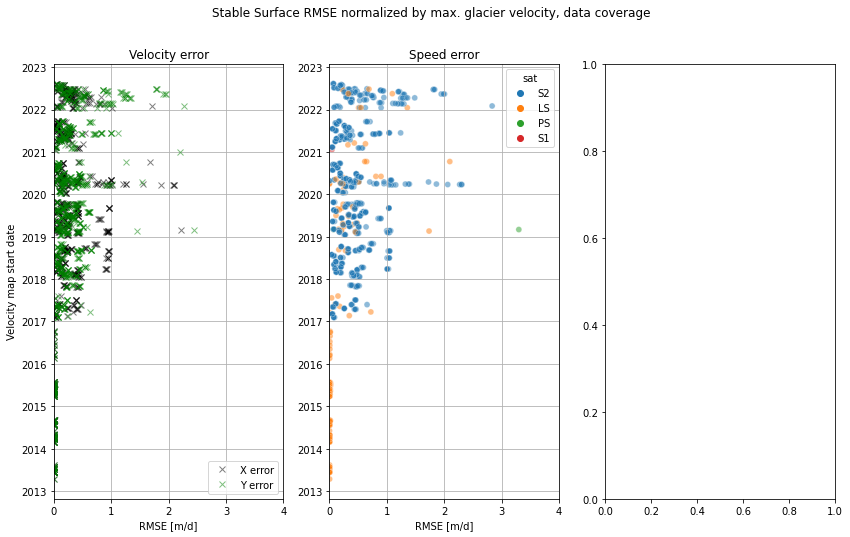

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,8))

# 1) plot velocity residuals over stable surfaces, scaled by max speed
ax1.set_title("Velocity error")
# # non-scaled velocities
ax1.plot(df.err_vx,pd.to_datetime(df.ds1,format='%Y%m%d'), 'kx', alpha=0.5)
ax1.plot(df.err_vy,pd.to_datetime(df.ds1,format='%Y%m%d'), 'gx', alpha=0.5)
# scale by max velocity
# ax1.plot(df.err_vx/df.vmax_total,pd.to_datetime(df.ds1,format='%Y%m%d'), 'kx',alpha=0.5)
# ax1.plot(df.err_vy/df.vmax_total,pd.to_datetime(df.ds1,format='%Y%m%d'), 'gx',alpha=0.5)

ax1.set_xlim(0, 4)
ax1.set_xlabel('RMSE [m/d]'); ax1.set_ylabel('Velocity map start date');
ax1.legend(['X error','Y error'], loc='lower right')
ax1.grid()

# 2) plot speed residual of stable surfaces (scaled by max speed)
ax2.set_title("Speed error")
# sns.scatterplot(df.err_v,pd.to_datetime(df.ds1,format='%Y%m%d'),c=df.sat)
sns.scatterplot(data=df, x=df.err_v, 
                y=pd.to_datetime(df.ds1,format='%Y%m%d'), hue="sat",alpha=0.5, ax=ax2)
ax2.set_xlim(0,4)
# ax2.set_xlim(0, np.max(df.err_v)+0.1)
ax2.set_xlabel('RMSE [m/d]'); ax2.set_ylabel(' ')
ax2.grid()

# # 3) percent coverage on glacier
# ax3.set_title("Data coverage")
# ax3.plot(df.data_percent,pd.to_datetime(df.ds1,format='%Y%m%d'), 'kx')
# ax3.set_xlim(0,100)
# ax3.set_xlabel('Pixels with data on glacier [%]')
# ax3.grid()

plt.suptitle('Stable Surface RMSE normalized by max. glacier velocity, data coverage')
plt.show()

In [234]:
df = df[(df.sat == 'S2') | (df.sat == 'LS')]

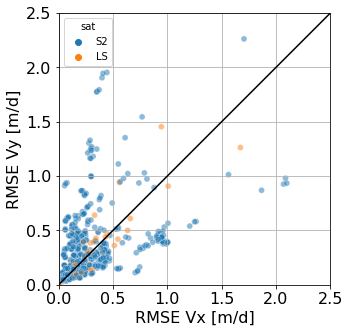

In [241]:
# Plot x vs. y velocity error
plt.figure(figsize=(5,5))
fs = 16
plt.axes().set_aspect('equal')
plt.grid()
sns.scatterplot(data=df, x=df.err_vx, 
                y=df.err_vy, hue="sat",alpha=0.5)
plt.plot([0,3],[0,3], 'k')
plt.xlabel('RMSE Vx [m/d]', fontsize=fs)
plt.ylabel('RMSE Vy [m/d]', fontsize=fs)
# plt.legend()
# plt.legend(['Sentinel-2','Landsat 8'])
plt.xlim(0,2.5); plt.ylim(0,2.5)
plt.tick_params(labelsize=fs)
plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/autoRIFT_errors_RMSEvx_vy_crossplot.png', dpi=200)
plt.show()

### Compare coverage by chip size

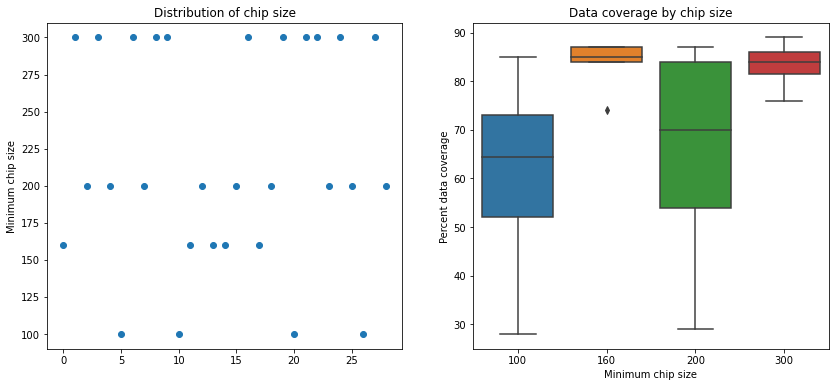

In [15]:
# plot chipsize distribution
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(df.min_chip_size, 'o')
ax1.set_ylabel('Minimum chip size')
ax1.set_title('Distribution of chip size')

ax2.set_title("Data coverage by chip size")
sns.boxplot(x="min_chip_size", y="data_percent", data=df, ax=ax2)
ax2.set_ylabel('Percent data coverage')
ax2.set_xlabel('Minimum chip size')

plt.show()

# 2B) Speed through points in zones

In [6]:
# read in the shapefiles with points in zones
######################################################################
zoneptpath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/cline_points_in_zones.shp'
zone_pts = fiona.open(zoneptpath)
# read in glacier shapefile and grab outline as shapes
with fiona.open('/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/Turner_RGI/TG_glims_polygon_UTM7.shp') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
######################################################################
for pt in zone_pts:
    km_mark = int(30 - pt['properties']['distance']/1000)
    print(km_mark)

17
22
28
24
18
15
9
5
1


In [7]:
# initialize lists to store info for each velocity map
ds1s = []; ds2s = []; dts = []; chipsizes = []; sats = []; data_fracs = []; err_vx = []; err_vy = []; err_v = []; 
s1 = []; s5 = []; s9 = []; s15 = []; s18 = []; s24 = []; s28 = []; s22 = []; s17 = [] # lists to hold speed at pts along centerline

file_count = 0
# for each velocity map
for output in os.listdir(autorift_outp):
    if output.startswith('velocity') and output.endswith('.tif'):
        [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
        d1 = datetime.datetime.strptime(ds1, '%Y%m%d'); d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
        dt = d2-d1
        sat = sat.split('.')[0] # s
        ds1s.append(ds1); ds2s.append(ds2); dts.append(dt.days)
        chipsizes.append(int(chipsize[:-1])); sats.append(sat)
        
        # read in the velocity map
        v_reader = rio.open(autorift_outp+output)
        vx = v_reader.read(1); vy = v_reader.read(2) # grab vx and vy
        v = np.sqrt(vx**2 + vy**2) # calculate vmag from vx and vy
        # raster grid value (UTM coordinates)
        x_vals = np.arange(v_reader.bounds.left, v_reader.bounds.right+1, v_reader.transform[0])
        y_vals = np.arange(v_reader.bounds.bottom, v_reader.bounds.top+1, v_reader.transform[0])
        
        # Read in stable surface mask
        ssm_reader = rio.open(refvpath+'ssm_'+chipsize+'.tif') # stable surface mask
        ssm = ssm_reader.read(1)
        if ssm.shape != vx.shape:
            ssm = ssm[:vx.shape[0],:vx.shape[1]]
        
        # grab data fraction in glacier outline
        cropped_img, cropped_transform = mask(v_reader, shapes, nodata= -3e5, crop=True)
        if cropped_img.shape[0] == 3:
            cropped_v = cropped_img[2] # grab the third band [2]
        else:
            cropped_vx = cropped_img[0]; cropped_vy = cropped_img[1]
            cropped_v = np.sqrt(cropped_vx**2 + cropped_vy**2) 
        cropped_v_filled = cropped_v.copy()
        cropped_v_filled[np.isnan(cropped_v_filled)] = 0 # fill all Nans with 0
        total_pixels = np.count_nonzero(cropped_v_filled >= 0) # count number of non-nodata values (negative)
        cropped_v[cropped_v < 0] = np.NaN # turn no data values (negative) into NaNs
        pixels_w_data = len(cropped_v[cropped_v >= 0]) # count non Nans (number of pixels with data)
        if pixels_w_data > 0:
            data_percent = int(pixels_w_data/total_pixels*100)
            data_fracs.append(data_percent)
            empty = False
        else:
            data_fracs.append(0)
            empty = True
#         plt.imshow(cropped_v); plt.colorbar(); plt.title(str(data_percent)+' %'); plt.show() # check visually
            
        # if no data left, just append nans to all the lists
        if empty: 
            for speedlist in [s1, s5, s9, s15, s18, s24, s28, s22, s17]:
                speedlist.append(np.NaN)
        # otherwise, extract the values
        else:
            for pt in zone_pts:
                [UTMx,UTMy] = pt['geometry']['coordinates'] # UTMx and y
                km_mark = int(30 - pt['properties']['distance']/1000)

                # find closest velocity raster grid cell
                y_idx = np.nanargmin(np.abs(y_vals - UTMy))
                y_idx = vx.shape[0] - y_idx # flip the yidx
                x_idx = np.nanargmin(np.abs(x_vals - UTMx))
                s = v[y_idx, x_idx]

                if km_mark == 1:
                    s1.append(s)
                elif km_mark == 5:
                    s5.append(s)
                elif km_mark == 9: 
                    s9.append(s)
                elif km_mark == 15:
                    s15.append(s)
                elif km_mark == 18:
                    s18.append(s)
                elif km_mark == 24:
                    s24.append(s)
                elif km_mark == 28:
                    s28.append(s)
                elif km_mark == 22:
                    s22.append(s)
                elif km_mark == 17:
                    s17.append(s)
                else:
                    print(km_mark, 'km mark not recognized.')
        
        # Grab off-ice velocities using stable surface mask
        ssm[ssm > 0] = 2 # turn ice into 2
        ssm[ssm == 0] = 1 # turn stable surfaces into 1
        ssm[ssm == 2] = 0 # turn ice into 0s
        ssm_masked_vx = ssm*vx; ssm_masked_vy = ssm*vy; ssm_masked_v = ssm*v 
        
        # calculate RMSE [m/d]
        err_vx.append(np.sqrt(np.nanmean(ssm_masked_vx**2))/365)
        err_vy.append(np.sqrt(np.nanmean(ssm_masked_vy**2))/365)
        err_v.append(np.sqrt(np.nanmean(ssm_masked_v**2))/365)
        
        # get ready for next iteration
        del v, vx, vy, empty
        file_count += 1
        
print(file_count, 'files found.')

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/4136277640.py:95: RuntimeWarning: Mean of empty slice
  err_vx.append(np.sqrt(np.nanmean(ssm_masked_vx**2))/365)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/4136277640.py:96: RuntimeWarning: Mean of empty slice
  err_vy.append(np.sqrt(np.nanmean(ssm_masked_vy**2))/365)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/4136277640.py:97: RuntimeWarning: Mean of empty slice
  err_v.append(np.sqrt(np.nanmean(ssm_masked_v**2))/365)


ValueError: Input shapes do not overlap raster.

In [ ]:
df = pd.DataFrame(list(zip(ds1s, ds2s, chipsizes, sats, dts, data_fracs, err_vx, err_vy, err_v,
                          s1, s5, s9, s15, s18, s24, s28, s22, s17)),
                 columns=['ds1','ds2','min_chip_size','sat','dt_days','data_percent',
                          'err_vx','err_vy','err_v',
                          's1', 's5', 's9','s15','s18','s24', 's28', 's22', 's17'])
df.sort_values(by=['ds1','min_chip_size','sat'])

In [60]:
df.to_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts.csv')

# 3) Identify a single velocity map per date pair

If there are multiple files for a pair of dates, grab the one corresponding to the best data coverage (df.data_precent) and lowest error(sqrt(err_vx^2 + err_vy^2)), show new centerline results.

In [186]:
#########################################
foldername = 'one_vmap_per_datepair/' # Set name for the folder to contained the filtered
# centerline velocities

# do this for only a certain time period:
startdate = datetime.datetime(2013,1,1)
enddate = datetime.datetime(2022,10,1)
print('Start at', startdate)
print('End at', enddate)
#########################################

Start at 2013-01-01 00:00:00
End at 2022-10-01 00:00:00


In [184]:
# # create the folder if it doesn't exist
# if not os.path.exists(cline_outpath+foldername):
#     os.mkdir(cline_outpath+foldername)
#     print('Subfolder created.')
# else:
#     print('Subfolder already exists.')
    
# # identify the unique date pairs
# ds1s = []; ds2s = [];
# for cfile in os.listdir(cline_outpath):
#     if cfile.endswith('.csv'):
#         if 's.' in cfile:
#             [ds1, ds2, sat, chipsize, n_or_s] = cfile.split('_')
#         else:
#             [ds1, ds2, sat, chipsize] = cfile.split('_')
#         chipsize = chipsize[:-5]
#         ds1s.append(ds1); ds2s.append(ds2)
# date_pairs = list(zip(ds1s,ds2s))
# unique_date_pairs = list(set(date_pairs))
# unique_date_pairs.sort()

In [185]:
# # copy over the single best map for the time period
# best_map_filenames = []
# for d1, d2 in unique_date_pairs:
#     ds1 = datetime.datetime.strptime(d1,'%Y%m%d')
#     ds2 = datetime.datetime.strptime(d2,'%Y%m%d')
    
#     if ds1 > startdate and ds2 < enddate:
#         files = glob.glob(cline_outpath+d1+'*'+d2+'*.csv') # grab all the csv files for date pair

#         if len(files) > 1: # if there are multiple
#             files_df = df[(df.ds1 == d1) & (df.ds2 == d2)] # grab all the entries in df
#             files_df = files_df.reset_index(drop=True)

#             # grab the one with the maximum data coverage
#             if np.count_nonzero(~np.isnan(files_df.data_percent)) > 0: # make sure not all NaNs
#                 max_idx = np.nanargmax(files_df.data_percent)
#                 if len(max_idx.shape) > 0: # if one maximum, use
#                     topfile = files_df.loc[max_idx] # greatest data coverage
#                 # if there are multiple with maximum data coverage move onto least error

#             # grab the one with the least error
#             if np.count_nonzero(~np.isnan(files_df.err_v)) > 0: # make sure not all NaNs
#                 topfile = files_df.loc[np.nanargmin(files_df.err_v)] # least speed error (err_v)
#             # try with err_vx and err_vy if not Nans
#             elif (np.count_nonzero(~np.isnan(files_df.err_vx)) > 0) and (np.count_nonzero(~np.isnan(files_df.err_vy)) > 0):
#                 topfile = files_df.loc[np.nanargmin(vector_magnitude(files_df.err_vx, files_df.err_vy))] 
#             else: # if error values are all nans
#                 if len(max_idx.shape) > 1: # and there were multiple with the same max. data coverage
#                     topfile = files_df.loc[max_idx[0]] # use the first one
#                 else: # if all were Nans
#                     topfile = files_df.loc[np.nanargmin(files_df.min_chip_size)] # use one w/ the smallest chip size

#             # find the file path corresponding to that file
#             for file in files:
#                 if topfile.ds1+'_'+topfile.ds2+'_'+topfile.sat+'_'+str(topfile.min_chip_size) in file:
#                     topfilepath = file       
#         else:
#             topfilepath = files[0] 

#         # move the file 
#         fname = topfilepath.split('/')[-1] # grab the filename
#         if not fname.endswith('_s.csv'):
#             shutil.copyfile(topfilepath, cline_outpath+foldername+fname)
#             best_map_filenames.append(fname)
        

In [182]:
# best_map_filenames

In [183]:
# # keep only best maps in the original dataframes
# print(len(df))
# for idx, row in df.iterrows():
#     fname = str(row.ds1)+'_'+str(row.ds2)+'_'+str(row.sat)+'_'+str(row.min_chip_size)+'m.csv'
    
#     # drop all the rows that do not contain the best file
#     if fname not in best_map_filenames:
#         df = df.drop(idx)
# print(len(df))

## Identify maps with overlapping dates, use output to manually filter

In [140]:
# ds1s = []; ds2s = []; chipsizes = []; fnames = []; 

# # filter out overlapping dates in the centerline folder
# for cfile in os.listdir(cline_outpath+foldername):
#     if cfile.endswith('.csv'):
#         if 's.' in cfile:
#             if n_or_s == 'n': # skip south
#                 continue
#             [ds1, ds2, sat, chipsize, n_or_s] = cfile.split('_')
#             chipsize = chipsize[:-1]
#         else:
#             [ds1, ds2, sat, chipsize] = cfile.split('_')
#             chipsize = chipsize[:-5]
#         ds1s.append(ds1); ds2s.append(ds2); 
#         chipsizes.append(int(chipsize)); fnames.append(cfile)

# # grab the date pairs
# dates_sort_df = pd.DataFrame(list(zip(ds1s,ds2s,chipsizes,fnames)), columns=['ds1','ds2','min_chip_size','fname'])

In [141]:
# dates_sort_df.sort_values(by='ds1',inplace=True)
# dates_sort_df = dates_sort_df.reset_index(drop=True)
# dates_sort_df

,ds1,ds2,min_chip_size,fname
0,20130414,20130610,200,20130414_20130610_LS_200m.csv
1,20130610,20130617,200,20130610_20130617_LS_200m.csv
2,20130617,20130712,200,20130617_20130712_LS_200m.csv
3,20130712,20130728,200,20130712_20130728_LS_200m.csv
4,20130728,20130813,200,20130728_20130813_LS_200m.csv
...,...,...,...,...
124,20220703,20220708,200,20220703_20220708_S2_200m.csv
125,20220708,20220729,200,20220708_20220729_S2_200m.csv
126,20220729,20220803,300,20220729_20220803_S2_300m.csv
127,20220803,20220812,300,20220803_20220812_S2_300m.csv


In [142]:
# for idx, row in dates_sort_df.iterrows():
#     if idx > 0: # start with second row
#         ds1 = dates_sort_df.loc[idx, 'ds1']
#         ds2 = dates_sort_df.loc[idx, 'ds2']
#         d1 = datetime.datetime.strptime(ds1, '%Y%m%d')
#         d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
#         fname = dates_sort_df.loc[idx, 'fname']
#         sat1 = fname.split('_')[2]; 
#         chipsize = dates_sort_df.loc[idx,'min_chip_size']
        
#         ds1_prev = dates_sort_df.loc[idx-1, 'ds1']
#         ds2_prev = dates_sort_df.loc[idx-1, 'ds2']
#         d1_prev = datetime.datetime.strptime(ds1_prev, '%Y%m%d')
#         d2_prev = datetime.datetime.strptime(ds2_prev, '%Y%m%d')
#         fname_prev = dates_sort_df.loc[idx-1, 'fname']
#         sat2 = fname_prev.split('_')[2]
#         chipsize_prev = dates_sort_df.loc[idx-1,'min_chip_size']
# #         chipsize_prev = fname_prev.split('_')[3][:-5]
# #         chipsize_prev = fname_prev.split('_')[3][:-1]
        
#         if d1 < d2_prev: # if overlapping time period found
#             print('Overlap found!')
#             print(fname, fname_prev)
            
            
#             fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
            
#             # grab entry from overall df
#             if sat1 != 'S1':
#                 df1 = df[(df.ds1 == ds1) & (df.ds2 == ds2) & 
#                          (df.sat == sat1) & (df.min_chip_size == int(chipsize))]
#                 dp1 = float(df1.data_percent); se1 = float(df1.err_v)
#                 rio1 = rio.open(autorift_outp+'velocity_'+ds1+'_'+ds2+'_'+str(chipsize)+'m_'+sat1+'.tif'); 
#                 vx1 = rio1.read(1)
#                 ax1.imshow(vx1); ax1.set_title(fname)
#             else:
#                 dp1 = np.NaN; se1 = np.NaN
                
#             if sat2 != 'S1':
#                 df2 = df[(df.ds1 == ds1_prev) & (df.ds2 == ds2_prev) & 
#                          (df.sat == sat2) & (df.min_chip_size == int(chipsize_prev))]
#                 dp2 = float(df2.data_percent); se2 = float(df2.err_v)
#                 rio2 = rio.open(autorift_outp+'velocity_'+ds1_prev+'_'+ds2_prev+'_'+str(chipsize_prev)+'m_'+sat2+'.tif'); 
#                 vx2 = rio2.read(1)
#                 ax2.imshow(vx2); ax2.set_title(fname_prev)
#             else:
#                 dp2 = np.NaN; se2 = np.NaN
            
#             # compare the data percent and speed error (NaNs for S1 data)
#             print('Data percent:', float(dp1), float(dp2))
#             print('Speed error:', float(se1), float(se2))
            
#             plt.show()
            

# 4) Plot speed time series for regional divisions

In [143]:
merged_df = dates_sort_df.merge(df, on=['ds1','ds2','min_chip_size'],how='left')
merged_df

,ds1,ds2,min_chip_size,fname,sat,data_percent,err_vx,err_vy,err_v,s1,s5,s9,s15,s18,s24,s28,s22,s17
0,20130414,20130610,200,20130414_20130610_LS_200m.csv,LS,1.0,0.007170,0.008478,0.011103,NaN,NaN,NaN,4.286216,2.616338,NaN,32.917679,2.511387,NaN
1,20130610,20130617,200,20130610_20130617_LS_200m.csv,LS,1.0,0.006384,0.005483,0.008415,41.737347,27.532837,26.202154,20.402853,13.041956,11.189964,7.555009,10.961170,20.178810
2,20130617,20130712,200,20130617_20130712_LS_200m.csv,LS,1.0,0.005772,0.004361,0.007234,NaN,65.631004,52.946159,28.961838,21.789158,35.738041,13.389486,9.516392,24.862745
3,20130712,20130728,200,20130712_20130728_LS_200m.csv,LS,1.0,0.003544,0.003249,0.004808,51.450970,21.133404,12.030539,4.482704,3.354817,24.380676,10.936187,0.286360,3.066195
4,20130728,20130813,200,20130728_20130813_LS_200m.csv,LS,1.0,0.001883,0.002118,0.002834,29.594913,7.512748,2.369111,0.591142,0.518466,17.199085,7.202945,0.259233,0.491860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,20220703,20220708,200,20220703_20220708_S2_200m.csv,S2,1.0,1.744708,1.003387,2.012658,260.102509,83.038750,68.437500,NaN,NaN,NaN,NaN,NaN,NaN
125,20220708,20220729,200,20220708_20220729_S2_200m.csv,S2,1.0,0.441739,0.594952,0.741013,53.563431,17.176062,209.660538,NaN,NaN,NaN,NaN,NaN,NaN
126,20220729,20220803,300,20220729_20220803_S2_300m.csv,S2,4.0,0.578672,0.651480,0.871371,438.807190,79.843750,216.718750,216.718750,205.312500,1517.074097,NaN,163.312637,114.062500
127,20220803,20220812,300,20220803_20220812_S2_300m.csv,S2,4.0,0.960395,0.428767,1.051761,572.034912,395.352661,299.711456,NaN,NaN,NaN,NaN,NaN,NaN


# 4A) Max speed in zones

In [1]:
# # Plot speeds - whole glacier
# fs = 14 # common fontsize

# # intiialize figure
# fig, ax = plt.subplots(1,figsize=(12,4))
# twin1 = ax.twinx()
# twin2 = ax.twinx()
# twin2.spines['right'].set_position(("axes", 1.1))

# middates = []; halfwidths = []
# for idx, row in merged_df.iterrows():
#     # calculate dates and box widths
#     date1 = datetime.datetime.strptime(row.ds1,'%Y%m%d')
#     date2 = datetime.datetime.strptime(row.ds2,'%Y%m%d')
#     mid_date = date1+ (date2-date1)/2 # calculate mid date
#     halfwidth = date2-mid_date # calculate the halfwdith
#     middates.append(mid_date)
#     halfwidths.append(halfwidth)
#     val = row.vmax_MT
    
#     # create the patch
#     pw = halfwidth*2 # width 
#     ph = row.err_v*2 # height
#     if ph < 0.25: # make minimum 0.25 height so we can see them
#         ph = 0.25
#     p = Rectangle((date1, val-row.err_v), # bottom left
#                   pw, # width
#                   ph, # height
#                   facecolor='black', alpha=0.8)
#     ax.add_patch(p) # add to figure
    
# merged_df['mid_date'] = middates # add mid_dates into dataframe 
# merged_df['dt_half'] = halfwidths # add halfwidths

# # TICKMARKS AND PLOT LIMITS
# ax.set_ylim(0, 36)
# # plt.xticks([datetime.datetime(2013,1,1),
# #            datetime.datetime(2014,1,1),
# #             datetime.datetime(2015,1,1),
# #             datetime.datetime(2016,1,1),
# #             datetime.datetime(2017,1,1),
# #             datetime.datetime(2018,1,1),
# plt.xticks([#datetime.datetime(2020,11,1),
#             #datetime.datetime(2020,9,1),
#             datetime.datetime(2021,1,1),
#             datetime.datetime(2021,3,1),
#             datetime.datetime(2021,5,1),
#             datetime.datetime(2021,7,1),
#             datetime.datetime(2021,9,1),
#             datetime.datetime(2021,11,1),])
# plt.xlim(datetime.datetime(2021,1,1), datetime.datetime(2021,11,1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))

# # WEATHER:
# # air temp:
# weather_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_211110/Hubbard for UIdaho/HUBWeatherJul2020_Jan2021.csv')
# weather_df_2 = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_211110/hub-haenke-2020-oct-20-to-2021-sep-28.csv')
# weather_df = weather_df.dropna(); weather_df_2 = weather_df_2.dropna()
# weather_df_2['datetimes'] = np.char.add(np.array(weather_df_2.Date,dtype=str), np.array(weather_df_2.Time,dtype=str))
# to_datetimes(weather_df, 'GMT','%d%b%Y %H%M') # Load weather data
# to_datetimes(weather_df_2,'datetimes','%m/%d/%y%H:%M:%S')
# dates =  np.concatenate((weather_df.GMT,weather_df_2.datetimes))
# temps = np.concatenate((weather_df['Temp-AIR1']*5/9 - 32,weather_df_2.Air_Temp1*9/5))
# p2, = twin1.plot(dates, temps,'-',linewidth=0.1,color='orange',alpha=1)
# twin1.tick_params(labelsize=fs); twin1.set_ylabel('Air Temp. ($^\circ$C)',fontsize=fs,color='orange')
# # twin1.set_ylim(18,58)

# # precipitation:
# precip_dates = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/ERA/ERA_2021_dates.csv',header=None)
# precip_values = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/ERA/ERA_2021_snowfall_values.csv',header=None)
# precip_df = pd.concat([precip_dates,precip_values],axis=1)
# precip_df.columns=['datetimes','variable']
# precip_df = to_datetimes(precip_df,'datetimes','%d-%b-%Y %H:%M:%S')
# twin2.plot(precip_df.datetimes, precip_df.variable*1000, 
#            color='blue',linewidth=0.5,alpha=0.6)
# twin2.set_ylim(0,52)
# twin2.tick_params(labelsize=fs)
# # twin2.set_ylabel('Precipitation [mm w.e. $hr^{-1}$]',fontsize=fs,color='blue')
# twin2.set_ylabel('Snowfall [m w.e.]',fontsize=fs,color='blue')
# # twin2.set_ylabel('Snowmelt [cm w.e. $hr^{-1}$]',fontsize=fs,color='blue')

# # # set spine colors
# # ax.yaxis.label.set_color(p1.get_color())
# # twin1.yaxis.label.set_color('blue')
# # twin2.yaxis.label.set_color(p3.get_color())


# # PLOT VISUALS
# ax.set_ylabel('Main trunk maximum \n surface speed [m/d]', fontsize=fs)
# # plt.title('Maximum speed of the main trunk',fontsize=fs)
# ax.tick_params('both',labelsize=fs)
# ax.grid()
# plt.show()

In [35]:
df.head()

,ds1,ds2,min_chip_size,sat,data_percent,err_vx,err_vy,err_v,vmax_MT,vmax_NT,vmax_ST,vmax_total,vmax_AI,vmax_RZ,vmax_TZ,vmax_IF
0,20190327,20190401,160,S2,85,-0.018600,-1.669649,1.705111,5.474461,15.566295,3.908249,15.566295,13.445674,6.514707,2.692038,15.566295
1,20150515,20150522,300,LS,89,-0.004896,0.005992,0.013826,0.023409,0.092654,0.024153,0.092654,0.092654,0.050765,0.021861,0.074459
2,20220519,20220522,200,S2,29,-0.373418,-1.497770,1.708380,7.944373,0.000000,0.000000,7.023336,0.000000,3.773077,7.944373,0.000000
3,20200402,20200405,300,S2,81,0.372338,-0.279329,3.063372,13.084532,16.124398,11.468390,16.124398,12.954519,13.084532,12.420101,16.124398
4,20180516,20180531,200,S2,84,0.662018,0.148000,0.710770,2.015564,8.569853,2.782089,8.569853,8.569853,4.399053,1.224435,7.493240


## Compare speeds in north tributary, south tributary, main trunk only

In [178]:
# # Plot speeds r
# fs = 14 # common fontsize

# fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

# for idx, row in df.iterrows():
#     date1 = datetime.datetime.strptime(row.ds1,'%Y%m%d')
#     date2 = datetime.datetime.strptime(row.ds2,'%Y%m%d')
#     mid_date = date1+(date2-date1)/2
#     halfwidth = date2-mid_date
#     valN = row.vmax_NT
#     valS = row.vmax_ST
#     valM = row.vmax_total
    
#     # create the patch
#     pw = halfwidth*2 # width 
#     ph = row.err_v*2 # height
#     if ph < 0.25: # make minimum 0.25 height so we can see them
#         ph = 0.25
    
#     # create and add rectangle
#     pN = patches.Rectangle((date1, valN-row.err_v),pw,ph,facecolor='red', alpha=0.5)
#     pS = patches.Rectangle((date1, valS-row.err_v),pw,ph,facecolor='steelblue', alpha=0.5)
#     pM = patches.Rectangle((date1, valM-row.err_v),pw,ph,facecolor='black', alpha=0.5)
#     ax1.add_patch(pN); ax2.add_patch(pS); ax3.add_patch(pM) # add to figure

# # TICKMARKS AND PLOT LIMITS
# ax1.tick_params(axis='both', labelsize=fs, labelbottom=False)
# ax1.set_ylim(0,40)
# ax1.grid()
# ax1.set_ylabel('North tributary only',fontsize=fs, color='red')

# ax2.tick_params(axis='both', labelsize=fs,labelbottom=False)
# ax2.set_ylim(0,40)
# ax2.grid()
# ax2.set_ylabel('South tributary only',fontsize=fs, color='steelblue')

# ax3.tick_params(axis='both', labelsize=fs)
# ax3.set_ylim(0,40)
# ax3.grid()
# ax3.set_ylabel('Main trunk only',fontsize=fs,color='black')

# # x axis:
# ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
# ax3.set_xticks([datetime.datetime(2013,1,1),
#            datetime.datetime(2014,1,1),
#             datetime.datetime(2015,1,1),
#             datetime.datetime(2016,1,1),
#             datetime.datetime(2017,1,1),
#             datetime.datetime(2018,1,1),
#             datetime.datetime(2019,1,1),
#             datetime.datetime(2020,1,1),
#             datetime.datetime(2021,1,1),
#             datetime.datetime(2022,1,1),
#                datetime.datetime(2023,1,1)])
# ax3.set_xlim(datetime.datetime(2013,1,1), datetime.datetime(2023,1,1))


# # whole plot:
# fig.supylabel('Maximum surface speed [m/d]', fontsize=fs+2)
# plt.subplots_adjust(wspace=0, hspace=0.1)
# fig.tight_layout() 
# plt.show()

In [179]:
# # Plot speeds r
# fs = 22 # common fontsize

# # fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(12,15), sharex=True, sharey=True)
# fig, (ax1, ax3, ax4) = plt.subplots(3,1,figsize=(12,12), sharex=True, sharey=True)

# for idx, row in df.iterrows():
#     date1 = datetime.datetime.strptime(row.ds1,'%Y%m%d')
#     date2 = datetime.datetime.strptime(row.ds2,'%Y%m%d')
#     mid_date = date1+(date2-date1)/2
#     halfwidth = date2-mid_date
#     valN = row.vmax_AI # above icefall
#     valS = row.vmax_RZ # reservior zone
#     valM = row.vmax_TZ # recieving zone
#     valI = row.vmax_IF # icefall
    
#     # create the patch
#     pw = halfwidth*2 # width 
#     ph = row.err_v*2 # height
#     if ph < 0.25: # make minimum 0.25 height so we can see them
#         ph = 0.25
    
#     # create and add rectangle
#     pN = patches.Rectangle((date1, valN-row.err_v),pw,ph,facecolor='orange', alpha=0.5)
#     pS = patches.Rectangle((date1, valS-row.err_v),pw,ph,facecolor='purple', alpha=0.5)
#     pM = patches.Rectangle((date1, valM-row.err_v),pw,ph,facecolor='yellowgreen', alpha=0.5)
#     pI = patches.Rectangle((date1, valI-row.err_v),pw,ph,facecolor='fuchsia', alpha=0.5)
#     ax1.add_patch(pN); ax3.add_patch(pS); ax4.add_patch(pM); #ax2.add_patch(pI) # add to figure

# #     # REPLACE WITH BOX:
# #     ax1.plot([date1, date2], [valN, valN] , '-',color='red',linewidth=3) # PLOT LINES
# #     ax1.errorbar(mid_date,valN,yerr=row.err_v,ecolor='red') # y-errorbar
    
# #     ax2.plot([date1, date2], [valS, valS] , '-',color='steelblue',linewidth=3) # PLOT LINES
# #     ax2.errorbar(mid_date,valS,yerr=row.err_v,ecolor='steelblue') # y-errorbar

# # TICKMARKS AND PLOT LIMITS
# ax1.tick_params(axis='both', labelsize=fs, labelbottom=False)
# ax1.grid()
# ax1.set_ylabel('Above icefall',fontsize=fs, color='orange')

# # ax2.tick_params(axis='both', labelsize=fs,labelbottom=False)
# # ax2.grid()
# # ax2.set_ylabel('Icefall',fontsize=fs, color='fuchsia')

# ax3.tick_params(axis='both', labelsize=fs)
# ax3.grid()
# ax3.set_ylabel('Reservior zone',fontsize=fs,color='purple')

# ax4.tick_params(axis='both', labelsize=fs)
# ax4.set_ylim(0,40)
# ax4.grid()
# ax4.set_ylabel('Receiving zone',fontsize=fs,color='yellowgreen')

# # x axis:
# ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
# ax3.set_xticks([datetime.datetime(2013,1,1),
#            datetime.datetime(2014,1,1),
#             datetime.datetime(2015,1,1),
#             datetime.datetime(2016,1,1),
#             datetime.datetime(2017,1,1),
#             datetime.datetime(2018,1,1),
#             datetime.datetime(2019,1,1),
#             datetime.datetime(2020,1,1),
#             datetime.datetime(2021,1,1),
#             datetime.datetime(2022,1,1),
#                datetime.datetime(2023,1,1)])
# ax3.set_xlim(datetime.datetime(2013,1,1), datetime.datetime(2023,1,1))


# # whole plot:
# fig.supylabel('Maximum surface speed [m/d]', fontsize=fs+2)
# plt.subplots_adjust(wspace=0, hspace=0.1)
# fig.tight_layout() 
# plt.show()

# 4B) Speed through points in zones

In [133]:
df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts_S1_included_adjustedssm.csv')
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ds1,ds2,min_chip_size,sat,dt_days,data_percent,err_vx,...,s1,s5,s9,s15,s18,s24,s28,s22,s17,Unnamed: 0.1.1.1
0,0,0,0.0,20190327,20190401,160,S2,5,97.0,0.060632,...,645.234924,594.877197,653.250549,1633.046753,2232.888184,2710.370850,1506.488892,573.610779,707.003540,NaN
1,1,1,1.0,20150515,20150522,300,LS,7,99.0,0.003403,...,2.860045,5.661819,6.952041,7.474257,12.785855,27.424217,15.302672,3.499182,1.520792,NaN
2,2,4,4.0,20180516,20180531,200,S2,15,96.0,0.198815,...,240.284439,224.837860,323.378326,508.882996,1163.835083,2492.757812,1184.115479,808.307129,310.958344,NaN
3,3,5,5.0,20170416,20170423,100,S2,7,79.0,0.420859,...,535.806396,606.050049,701.468567,NaN,2892.058105,2150.414551,428.180298,1759.702271,224.162415,NaN
4,4,6,6.0,20171104,20171109,300,S2,5,96.0,0.211964,...,494.859070,526.729187,587.990112,614.245361,780.724304,2365.497803,2171.685303,817.757324,570.084290,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,112,112,NaN,20191128,20191210,120,S1,12,NaN,NaN,...,33.000000,125.000000,NaN,173.000000,385.000000,NaN,851.000000,29.000000,133.000000,NaN
743,113,113,NaN,20170717,20170729,120,S1,12,NaN,NaN,...,113.000000,121.000000,NaN,1039.000000,NaN,NaN,840.000000,NaN,NaN,NaN
744,114,114,NaN,20220329,20220410,120,S1,12,NaN,NaN,...,474.000000,113.000000,NaN,NaN,NaN,NaN,1105.000000,171.000000,73.000000,NaN
745,115,115,NaN,20200725,20200806,120,S1,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1054.000000,NaN,NaN,NaN


In [26]:
# # df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts.csv')
# df = df[(df.sat == 'S2') | (df.sat == 'LS')]
# df_s1 = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts_S1.csv')
# df_s1['dt_days'] = (pd.to_datetime(df_s1.ds2, format='%Y%m%d') - pd.to_datetime(df_s1.ds1,format='%Y%m%d')).dt.days
# # concatenate the optical and S1 data together
# df = pd.concat([df, df_s1])
# df

,Unnamed: 0,Unnamed: 0.1,ds1,ds2,min_chip_size,sat,err_vx,err_vy,err_v,s1,s5,s9,s15,s18,s24,s28,s22,s17,dt_days
0,0,0.0,20190327,20190401,160,S2,0.621113,1.766666,1.872670,645.234900,594.87720,653.250550,1633.046800,2232.888200,2710.370800,1506.488900,573.610800,707.003540,NaN
1,1,1.0,20150515,20150522,300,LS,0.013962,0.008276,0.016231,2.860045,5.66182,6.952041,7.474257,12.785855,27.424217,15.302672,3.499182,1.520792,NaN
2,2,2.0,20220519,20220522,200,S2,1.301522,2.252060,2.601103,932.092200,544.37550,697.192600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,20200402,20200405,300,S2,3.426699,1.380143,3.694193,1720.836500,1881.64710,1008.269170,4278.400000,3244.549600,3242.822500,2146.830800,2947.166500,3303.494100,NaN
4,4,4.0,20180516,20180531,200,S2,0.689447,0.306537,0.754521,240.284440,224.83786,323.378330,508.883000,1163.835100,2492.757800,1184.115500,808.307100,310.958340,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,NaN,20191128,20191210,120,S1,NaN,NaN,0.279730,33.000000,125.00000,NaN,173.000000,385.000000,NaN,851.000000,29.000000,133.000000,12.0
113,113,NaN,20170717,20170729,120,S1,NaN,NaN,0.157873,113.000000,121.00000,NaN,1039.000000,NaN,NaN,840.000000,NaN,NaN,12.0
114,114,NaN,20220329,20220410,120,S1,NaN,NaN,0.285337,474.000000,113.00000,NaN,NaN,NaN,NaN,1105.000000,171.000000,73.000000,12.0
115,115,NaN,20200725,20200806,120,S1,NaN,NaN,0.169863,NaN,NaN,NaN,NaN,NaN,NaN,1054.000000,NaN,NaN,12.0


In [10]:
# df.to_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts_S1_included_adjustedssm.csv')

In [18]:
# read in terminus positions
tpos_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/figures/terminus_positions_2013_2022.csv', 
                      index_col=0)
tpos_df.datetime = pd.to_datetime(tpos_df.datetime)
tpos_df = tpos_df.sort_values(by='datetime')
tpos_df.head()

,datetime,image_name,area_km2,embayment,plume,error_km2
10,2013-04-14,LC08_L1TP_062018_20130414_20200912_02_T1,7.99177,0,1,0.359151
11,2013-06-10,LC08_L1TP_061018_20130610_20200912_02_T1,8.23238,0,1,0.359151
9,2013-06-17,LC08_L1TP_062018_20130617_20200912_02_T1,8.13977,0,1,0.359151
5,2013-07-12,LC08_L1TP_061018_20130712_20200912_02_T1,8.26437,0,1,0.359151
4,2013-07-28,LC08_L1TP_061018_20130728_20200912_02_T1,8.10047,0,1,0.359151


In [130]:
# # grab unique date pairs
# unique_date_pairs = list(set(list(zip(df.ds1, df.ds2))))
# unique_date_pairs.sort() # sort

# bad_pairs = [(20170220, 20170317),
#              (20170205, 20170307),
#              (20190219, 20190226),
#              (20190501, 20190627),
#              (20200213, 20200401),
#              (20210211, 20210402),
#              (20220117, 20220202),
#              (20190330, 20190415),
#              (20170527, 20170723),
#              (20180329, 20180401),
#              (20200417, 20200512)
#             ]

# for ds1, ds2 in unique_date_pairs:
#     if (ds1, ds2) in bad_pairs:
#         unique_date_pairs.remove((ds1, ds2))
#         print(ds1, ds2)
        
#         index = df[(df.ds1 == ds1) & (df.ds2 == ds2) ].index
#         df.drop(index, inplace=True) # drop from dataframe

In [37]:
# drop all date pairs where dt is less than 5 days
df.drop(df[df.dt_days < 5].index, inplace=True)

In [131]:
# len(unique_date_pairs)

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/430843026.py:49: RuntimeWarning: Mean of empty slice
  s9 = np.nanmean(datepair_df.s9); s15 = np.nanmean(datepair_df.s15); s18 = np.nanmean(datepair_df.s18)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/430843026.py:37: RuntimeWarning: Mean of empty slice
  s24 = np.nanmean(datepair_df.s24); s28 = np.nanmean(datepair_df.s28)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/430843026.py:56: RuntimeWarning: Mean of empty slice
  s1 = np.nanmean(datepair_df.s1); s5 = np.nanmean(datepair_df.s5)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/430843026.py:43: RuntimeWarning: Mean of empty slice
  s17 = np.nanmean(datepair_df.s17); s22 = np.nanmean(datepair_df.s22)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/430843026.py:25: RuntimeWarning: Mean of empty slice
  speed_err = np.nanmean(datepair_df.err_v) # RMSE


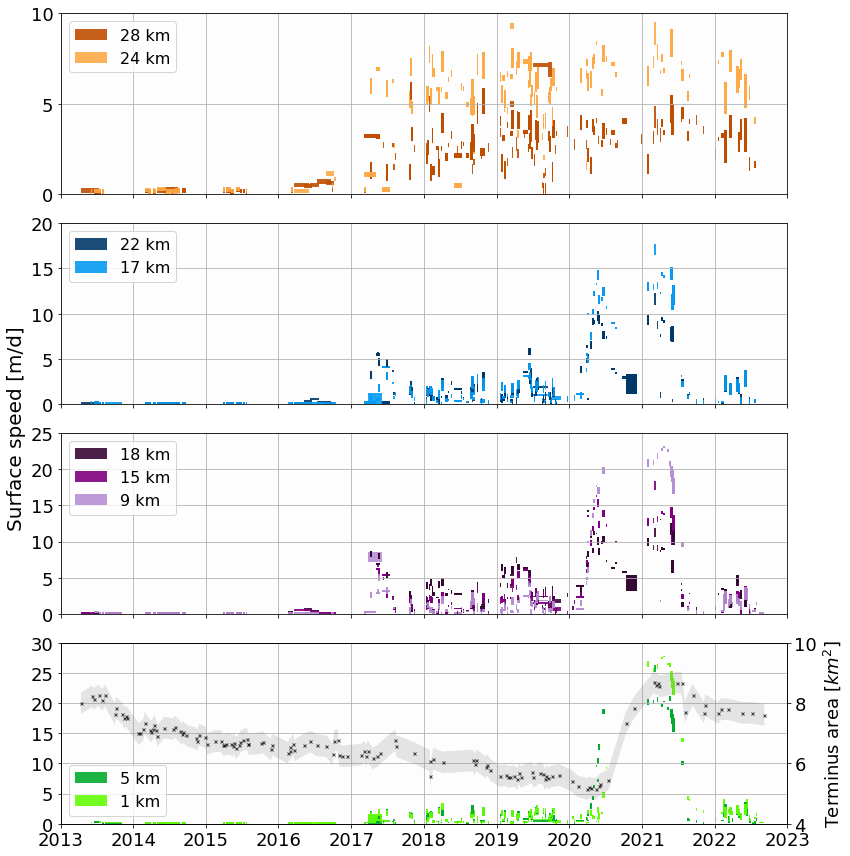

In [134]:
# Plot speeds
fs = 18 # common fontsize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(12,12), sharex=True)
tpos_ax = ax4.twinx()
background_col='xkcd:pale grey'
ms = 1 # markersize for all points
a = 0.9 # alpha value for all patches

# PLOT TERMINUS POSITION
tpos_ax.fill_between(tpos_df.datetime,tpos_df.area_km2 - tpos_df.error_km2, 
                     tpos_df.area_km2 + tpos_df.error_km2, color='gray', edgecolor=None, alpha=0.2)
tpos_ax.plot(tpos_df.datetime, tpos_df.area_km2,'kx',markersize=3,alpha=0.7)

for ds1, ds2 in list(zip(df.ds1,df.ds2)):
    datepair_df = df[(df.ds1 == ds1) & (df.ds2 == ds2)]
    
    # grab date
    date1 = datetime.datetime.strptime(str(ds1),'%Y%m%d')
    date2 = datetime.datetime.strptime(str(ds2),'%Y%m%d')
    dt_days = list(datepair_df.dt_days)[0] # grab the time separation
    mid_date = date1+(dt)/2
    halfwidth = date2-mid_date # need halfwidth of dt for patch plotting
    
    # calculate mean error
    speed_err = np.nanmean(datepair_df.err_v) # RMSE

    # create the patch
    pw = halfwidth*2 # width 
    ph = speed_err*2 # height
    if ph < 0.25: # make minimum 0.25 height so we can see them
        ph = 0.25
    
#     if dt_days < 50:
    if dt_days >= 5:
         # plot patches and points by each region subplot
        # 1) above icefall - orange
        s24 = np.nanmean(datepair_df.s24); s28 = np.nanmean(datepair_df.s28)
        p24 = patches.Rectangle((date1, s24/365-speed_err),pw,ph,facecolor='#fdaa48', alpha=a) # light orange
        p28 = patches.Rectangle((date1, s28/365-speed_err),pw,ph,facecolor='#c04e01',alpha=a) # burnt orange
        ax1.add_patch(p28); ax1.add_patch(p24);  

        # 2) reservior zone (south) - blue
        s17 = np.nanmean(datepair_df.s17); s22 = np.nanmean(datepair_df.s22)
        p17 = patches.Rectangle((date1, s17/365-speed_err),pw,ph,facecolor='#069af3', alpha=a) # azure
        p22 = patches.Rectangle((date1, s22/365-speed_err),pw,ph,facecolor='#01386a', alpha=a) # marine blue
        ax2.add_patch(p22); ax2.add_patch(p17) 

        # 3) reservior zone (north) - purple
        s9 = np.nanmean(datepair_df.s9); s15 = np.nanmean(datepair_df.s15); s18 = np.nanmean(datepair_df.s18)
        p9 = patches.Rectangle((date1, s9/365-speed_err),pw,ph,facecolor='#b790d4', alpha=a) # pale purple
        p15 = patches.Rectangle((date1, s15/365-speed_err),pw,ph,facecolor='purple',alpha=a) # purple
        p18 = patches.Rectangle((date1, s18/365-speed_err),pw,ph,facecolor='#380835',alpha=a) # egg plant
        ax3.add_patch(p18); ax3.add_patch(p15); ax3.add_patch(p9); 

        # 4) recieving zone - green
        s1 = np.nanmean(datepair_df.s1); s5 = np.nanmean(datepair_df.s5)
        p1 = patches.Rectangle((date1, s1/365-speed_err),pw,ph,facecolor='#65fe08', alpha=a) # bright lime green
        p5 = patches.Rectangle((date1, s5/365-speed_err),pw,ph,facecolor='#02ab2e', alpha=a) # kelly green
        ax4.add_patch(p5); ax4.add_patch(p1); 

    
# TICKMARKS AND PLOT LIMITS
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_yticks([0,5,10,15,20,25,30])
#     ax.set_ylim(0,30)
    
ax1.tick_params(axis='both', labelsize=fs, labelbottom=False); ax1.grid()
# ax1.set_ylabel('Above icefall',fontsize=fs, color='orange') # plot as text instead
ax1.legend(['28 km','24 km'], fontsize=fs-2)
ax1.set_ylim(0,10)

ax2.tick_params(axis='both', labelsize=fs, labelbottom=False); ax3.grid()
# ax2.set_ylabel('Reservior zone\n(Southern tributary)',fontsize=fs,color='blue')
ax2.legend(['22 km','17 km'], fontsize=fs-2)
ax2.set_ylim(0,20)

ax3.tick_params(axis='both', labelsize=fs, labelbottom=False); ax2.grid()
# ax3.set_ylabel('Reservior zone',fontsize=fs,color='purple')
ax3.legend(['18 km','15 km', '9 km'], fontsize=fs-2)
ax3.set_ylim(0,25)

ax4.tick_params(axis='both', labelsize=fs); ax4.grid()
# ax4.set_ylabel('Receiving zone',fontsize=fs,color='green')
ax4.legend(['5 km', '1 km'], loc='lower left', fontsize=fs-2)
ax4.set_ylim(0,30)

# terminus position secondary ax
tpos_ax.tick_params(axis='both', labelsize=fs, labelbottom=False)
tpos_ax.set_ylabel('Terminus area [$km^2$]', fontsize=fs, color='black')
tpos_ax.set_ylim(4,10)

# whole plot:
# x-axis
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax4.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
ax4.set_xticks([datetime.datetime(2013,1,1),
           datetime.datetime(2014,1,1),
            datetime.datetime(2015,1,1),
            datetime.datetime(2016,1,1),
            datetime.datetime(2017,1,1),
            datetime.datetime(2018,1,1),
            datetime.datetime(2019,1,1),
            datetime.datetime(2020,1,1),
            datetime.datetime(2021,1,1),
            datetime.datetime(2022,1,1),
               datetime.datetime(2023,1,1)])
ax4.set_xlim(datetime.datetime(2013,1,1), datetime.datetime(2023,1,1))
# set background color
ax1.set_facecolor(background_col); ax2.set_facecolor(background_col);
ax3.set_facecolor(background_col); ax4.set_facecolor(background_col);

# labels and layout
fig.supylabel('Surface speed [m/d]', fontsize=fs+2)
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout() 
# plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speed_timeseries_zone_pts_wS1.png',dpi=300)
plt.show()

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/1407015251.py:22: RuntimeWarning: Mean of empty slice
  s9 = np.nanmean(datepair_df.s9); s15 = np.nanmean(datepair_df.s15); s18 = np.nanmean(datepair_df.s18)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_22297/1407015251.py:27: RuntimeWarning: Mean of empty slice
  s1 = np.nanmean(datepair_df.s1); s5 = np.nanmean(datepair_df.s5)


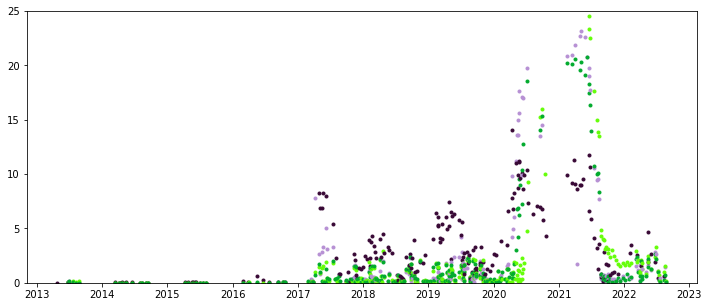

In [135]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
size=3
for ds1, ds2 in unique_date_pairs:
    datepair_df = df[(df.ds1 == ds1) & (df.ds2 == ds2)]
    
    # grab date
    date1 = datetime.datetime.strptime(str(ds1),'%Y%m%d')
    date2 = datetime.datetime.strptime(str(ds2),'%Y%m%d')
    dt_days = list(datepair_df.dt_days)[0] # grab the time separation
    mid_date = date1+(dt)/2

    if dt_days >= 5:
    
#         s24 = np.nanmean(datepair_df.s24); s28 = np.nanmean(datepair_df.s28)
#         ax.scatter(mid_date, s24, s=size,color='#fdaa48') # light orange
#         ax.scatter(mid_date, s28, s=size, color='#c04e01') # burnt orange
        
#         s17 = np.nanmean(datepair_df.s17); s22 = np.nanmean(datepair_df.s22)
#         ax.scatter(mid_date, s17, s=size, color='#069af3')
#         ax.scatter(mid_date, s22, s=size, color='#01386a')

        s9 = np.nanmean(datepair_df.s9); s15 = np.nanmean(datepair_df.s15); s18 = np.nanmean(datepair_df.s18)
        ax.plot(mid_date, s9/365, 'o-', markersize=size, color='#b790d4')
#         ax.plot(mid_date, s15/365,'o-', markersize=size, color='purple')
        ax.plot(mid_date, s18/365, 'o-', markersize=size, color='#380835')
        
        s1 = np.nanmean(datepair_df.s1); s5 = np.nanmean(datepair_df.s5)
        ax.plot(mid_date,s1/365,  'o-', markersize=size, color='#65fe08')
        ax.plot(mid_date, s5/365, 'o-', markersize=size, color='#02ab2e')
        
plt.ylim(0,25)
plt.show()

In [450]:
# # for identifying bad maps:
# df[(df.ds1 > 20180601) & (df.ds2 < 20181001) & (df.s18 > 5*365)].sort_values(by='s18')

# for identifying mean speed in the main trunk of the glacier 9,15,5,1
subset_df = df[(df.ds1 == 20200311) & (df.ds2 == 20200323)]
print(np.nanmean(list(subset_df.s28)+list(subset_df.s24)+list(subset_df.s18))/365)
# print(np.nanmean(list(subset_df.s15)+list(subset_df.s9)+list(subset_df.s5)+list(subset_df.s1))/365)
subset_df

5.205827679283741


,Unnamed: 0,Unnamed: 0.1,ds1,ds2,min_chip_size,sat,dt_days,data_percent,err_vx,err_vy,...,s1,s5,s9,s15,s18,s24,s28,s22,s17,Unnamed: 0.1.1
12,14,14,20200311,20200323,160,S2,12,84.0,0.249873,0.151461,...,456.348999,448.183441,643.587524,1345.490723,2135.273682,2430.644531,995.690430,1278.485962,580.382324,NaN
241,301,307,20200311,20200323,100,S2,12,82.0,0.262771,0.165944,...,469.835266,452.122314,691.989563,1238.634888,2719.328857,2377.618164,950.152466,1278.794922,635.535278,NaN
419,528,540,20200311,20200323,200,S2,12,86.0,0.245493,0.149770,...,407.755737,397.318817,524.296509,1337.138306,2341.447510,2459.209717,975.997864,957.446289,576.320679,NaN
567,717,731,20200311,20200323,300,S2,12,91.0,0.231067,0.154193,...,469.835266,509.416199,700.053955,1238.634888,NaN,2382.780518,1133.254395,1305.677979,622.754395,NaN


In [169]:
# # Plot speeds
# fs = 18 # common fontsize
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(12,12), sharex=True)
# tpos_ax = ax4.twinx()
# background_col='xkcd:pale grey'
# ms = 1 # markersize for all points
# a = 0.9 # alpha value for all patches

# # PLOT TERMINUS POSITION
# tpos_ax.fill_between(tpos_df.datetime,tpos_df.area_km2 - tpos_df.error_km2, 
#                      tpos_df.area_km2 + tpos_df.error_km2, color='gray', alpha=0.2)
# tpos_ax.plot(tpos_df.datetime, tpos_df.area_km2,'kx',markersize=3,alpha=0.7)

# for idx, row in df.iterrows():
#     # grab date
#     date1 = datetime.datetime.strptime(str(row.ds1),'%Y%m%d')
#     date2 = datetime.datetime.strptime(str(row.ds2),'%Y%m%d')
#     mid_date = date1+(date2-date1)/2
#     halfwidth = date2-mid_date # need halfwidth of dt for patch plotting
#     speed_err = row.err_v # stick with RMSE
    
#     # create the patch
#     pw = halfwidth*2 # width 
#     ph = speed_err*2 # height
#     if ph < 0.25: # make minimum 0.25 height so we can see them
#         ph = 0.25
    
#     # remove certain
    
#     # plot patches and points by each region subplot
#     # 1) above icefall - orange
#     p24 = patches.Rectangle((date1, row.s24/365-speed_err),pw,ph,facecolor='#fdaa48', alpha=a) # light orange
#     p28 = patches.Rectangle((date1, row.s28/365-speed_err),pw,ph,facecolor='#c04e01',alpha=a) # burnt orange
#     ax1.add_patch(p28); ax1.add_patch(p24);  
# #     ax1.scatter(mid_date, row.s24/365, color='#fdaa48',s=ms)
# #     ax1.scatter(mid_date, row.s28/365, color='#c04e01',s=ms)
    
#     # 2) reservior zone (south) - blue
#     p17 = patches.Rectangle((date1, row.s17/365-speed_err),pw,ph,facecolor='#069af3', alpha=a) # azure
#     p22 = patches.Rectangle((date1, row.s22/365-speed_err),pw,ph,facecolor='#01386a', alpha=a) # marine blue
#     ax2.add_patch(p22); ax2.add_patch(p17) 
# #     ax2.scatter(mid_date, row.s17/365, color='#069af3',s=ms)
# #     ax2.scatter(mid_date, row.s22/365, color='#01386a',s=ms)
     
#     # 3) reservior zone (north) - purple
#     p9 = patches.Rectangle((date1, row.s9/365-speed_err),pw,ph,facecolor='#b790d4', alpha=a) # pale purple
#     p15 = patches.Rectangle((date1, row.s15/365-speed_err),pw,ph,facecolor='purple',alpha=a) # purple
#     p18 = patches.Rectangle((date1, row.s18/365-speed_err),pw,ph,facecolor='#380835',alpha=a) # egg plant
#     ax3.add_patch(p18); ax3.add_patch(p15); ax3.add_patch(p9); 
# #     ax3.scatter(mid_date, row.s9/365, color='#b790d4',s=ms)
# #     ax3.scatter(mid_date, row.s15/365, color='purple',s=ms)
# #     ax3.scatter(mid_date, row.s18/365, color='#380835',s=ms)
    
#     # 4) recieving zone - green
#     p1 = patches.Rectangle((date1, row.s1/365-speed_err),pw,ph,facecolor='#65fe08', alpha=a) # bright lime green
#     p5 = patches.Rectangle((date1, row.s5/365-speed_err),pw,ph,facecolor='#02ab2e', alpha=a) # kelly green
#     ax4.add_patch(p5); ax4.add_patch(p1); 
# #     ax4.scatter(mid_date, row.s1/365, color='#65fe08',s=ms)
# #     ax4.scatter(mid_date, row.s5/365, color='#02ab2e',s=ms)

# # TICKMARKS AND PLOT LIMITS
# ax1.tick_params(axis='both', labelsize=fs, labelbottom=False); ax1.grid()
# # ax1.set_ylabel('Above icefall',fontsize=fs, color='orange') # plot as text instead
# ax1.legend(['28 km','24 km'], fontsize=fs-2)
# ax1.set_ylim(0,12)

# ax2.tick_params(axis='both', labelsize=fs, labelbottom=False); ax3.grid()
# # ax2.set_ylabel('Reservior zone\n(Southern tributary)',fontsize=fs,color='blue')
# ax2.legend(['22 km','17 km'], fontsize=fs-2)
# ax2.set_ylim(0,16)

# ax3.tick_params(axis='both', labelsize=fs, labelbottom=False); ax2.grid()
# # ax3.set_ylabel('Reservior zone',fontsize=fs,color='purple')
# ax3.legend(['18 km','15 km', '9 km'], fontsize=fs-2)
# ax3.set_ylim(0,25)

# ax4.tick_params(axis='both', labelsize=fs); ax4.grid()
# # ax4.set_ylabel('Receiving zone',fontsize=fs,color='green')
# ax4.legend(['5 km', '1 km'], loc='lower left', fontsize=fs-2)
# ax4.set_ylim(0,30)

# # terminus position secondary ax
# tpos_ax.tick_params(axis='both', labelsize=fs, labelbottom=False)
# tpos_ax.set_ylabel('Terminus area [$km^2$]', fontsize=fs, color='black')
# tpos_ax.set_ylim(4,10)

# # whole plot:
# # x-axis
# ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# ax4.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
# ax4.set_xticks([datetime.datetime(2013,1,1),
#            datetime.datetime(2014,1,1),
#             datetime.datetime(2015,1,1),
#             datetime.datetime(2016,1,1),
#             datetime.datetime(2017,1,1),
#             datetime.datetime(2018,1,1),
#             datetime.datetime(2019,1,1),
#             datetime.datetime(2020,1,1),
#             datetime.datetime(2021,1,1),
#             datetime.datetime(2022,1,1),
#                datetime.datetime(2023,1,1)])
# ax4.set_xlim(datetime.datetime(2013,1,1), datetime.datetime(2023,1,1))
# # set background color
# ax1.set_facecolor(background_col); ax2.set_facecolor(background_col);
# ax3.set_facecolor(background_col); ax4.set_facecolor(background_col);

# for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_yticks([0,5,10,15,20,25,30])

# # labels and layout
# fig.supylabel('Surface speed [m/d]', fontsize=fs+2)
# plt.subplots_adjust(wspace=0.1, hspace=0)
# fig.tight_layout() 
# plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speed_timeseries_zone_pts_wS1.png',dpi=300)
# plt.show()

In [281]:
# np.nanmean(df[(df.ds1 >= 20200818) & (df.ds2 <= 20200924)].s9)

In [282]:
# df[(df.ds1 >= 20200818) & (df.ds2 <= 20200924)].s9/365

# Plot comparison of speeds with Haenke temperatures

new_cases_daily_total_modified['Weeks'] =  
new_cases_daily_total_modified['Weeks'].astype('datetime64[ns]')

In [145]:
# generate table for supplementary table
mid_dates_col = []
date1_col = []
date2_col = []
for idx, row in df.iterrows():
    # grab date
    date1 = datetime.datetime.strptime(str(row.ds1),'%Y%m%d')
    date2 = datetime.datetime.strptime(str(row.ds2),'%Y%m%d')
    mid_date = date1+(date2-date1)/2
    
    
    mid_dates_col.append(str(mid_date)[0:10])
    date1_col.append(str(date1)[0:10])
    date2_col.append(str(date2)[0:10])
df['mid_date'] = mid_dates_col
df['date1'] = date1_col
df['date2'] = date2_col
df_table = df[['date1', 'date2', 'mid_date', 'dt_days','sat', 
               'min_chip_size','data_percent','err_vx','err_vy','err_v']]
df_table = df_table[df_table.data_percent != 0]
df_table = df_table[~np.isnan(df_table.err_v)]
df_table = df_table[df_table.min_chip_size <=300]
df_table = df_table.sort_values(by='mid_date')
df_table

,date1,date2,mid_date,dt_days,sat,min_chip_size,data_percent,err_vx,err_vy,err_v
542,2013-04-14,2013-06-10,2013-05-12,57,LS,200,72.0,0.002078,0.002548,0.003287
351,2013-06-10,2013-06-17,2013-06-13,7,LS,160,98.0,0.001716,0.000964,0.001968
157,2013-06-10,2013-06-17,2013-06-13,7,LS,200,98.0,0.001648,0.000867,0.001863
300,2013-06-10,2013-06-17,2013-06-13,7,LS,300,97.0,0.001707,0.000890,0.001925
595,2013-06-10,2013-06-17,2013-06-13,7,LS,100,98.0,0.003793,0.002414,0.004496
...,...,...,...,...,...,...,...,...,...,...
62,2022-08-03,2022-08-12,2022-08-07,9,S2,200,34.0,0.181011,0.114512,0.214192
533,2022-08-03,2022-08-12,2022-08-07,9,S2,100,35.0,0.178507,0.113307,0.211432
210,2022-08-12,2022-09-04,2022-08-23,23,S2,200,28.0,0.041963,0.054838,0.069052
46,2022-08-12,2022-09-04,2022-08-23,23,S2,300,28.0,0.036024,0.050980,0.062423


In [146]:
df_table.to_csv('/Users/jukesliu/Documents/TURNER/paper1/autorift_vmap_parameters_SK.csv')

In [74]:
from matplotlib.ticker import FormatStrFormatter

# add in weather data plot (daily_average):
def F_to_C(f_array):
    # converts array of temperatures in Farenheit to Celsuis
    f_array = np.array(f_array) # make sure it's a numpy array
    c_array = (f_array - 32)*5/9
    return c_array

weather_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_202209/wx_Haenke_2014_2022_nogap.csv')
weather_df.AKDT = pd.to_datetime(weather_df.AKDT) # convert to datetime
# weather_df.head()

# weekly (or monthly average)
weekly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='W')).mean() 
monthly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='M')).mean() 

weekly_df

,Temp-AIR1,Temp-AIR2,Temp-AVG
AKDT,,,
2013-01-06,NaN,NaN,NaN
2013-01-13,NaN,NaN,NaN
2013-01-20,NaN,NaN,NaN
2013-01-27,NaN,NaN,NaN
2013-02-03,NaN,NaN,NaN
...,...,...,...
2022-08-28,44.424554,43.575179,43.999866
2022-09-04,45.122380,44.306687,44.714533
2022-09-11,43.571429,42.787143,43.179286


In [87]:
# read runoff from Yoram
runoff_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/SK_runoff.csv',skiprows=24)
runoff_df['time'] = pd.to_datetime(runoff_df.time)
runoff_df

,km18,time,km14,km24
0,0.016721,2020-08-15 00:00:00,0.017337,0.013260
1,0.002213,2020-08-15 03:00:00,0.010211,0.004462
2,0.001902,2020-08-15 06:00:00,0.002626,0.003030
3,0.003665,2020-08-15 09:00:00,0.003557,0.001839
4,0.001100,2020-08-15 12:00:00,0.001298,0.000368
...,...,...,...,...
5836,0.000323,2022-08-14 12:00:00,0.000528,0.000084
5837,0.000184,2022-08-14 15:00:00,0.000287,0.000084
5838,0.001363,2022-08-14 18:00:00,0.001932,0.000084
5839,0.000684,2022-08-14 21:00:00,0.004687,0.000084


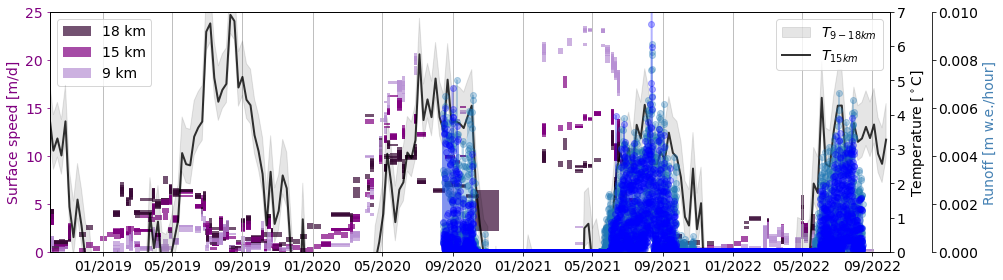

In [101]:
# Plot reservior zone speeds with temperature
LAPSE_RATE = -4 # degrees C/K per km
ELEV_HIGH = 973
ELEV_LOW = 574
ELEV_MEAN = 837
YEAR_RANGE = '2019-2022'
# YEAR_RANGE = '2015-2018'
WXCOLOR='black'
fs = 14
#######

fig, ax3 = plt.subplots(1,figsize=(14,4))
wx_ax = ax3.twinx() # make twinx with weather

for idx, row in df.iterrows():
    # grab date
    date1 = datetime.datetime.strptime(str(row.ds1),'%Y%m%d')
    date2 = datetime.datetime.strptime(str(row.ds2),'%Y%m%d')
    mid_date = date1+(date2-date1)/2
    halfwidth = date2-mid_date # need halfwidth of dt for patch plotting
    
    # create the patch
    pw = halfwidth*2 # width 
    ph = row.err_v*2 # height
    if ph < 0.25: # make minimum 0.25 height so we can see them
        ph = 0.25
    
    # plot patches and points by each region subplot
    ms = 1 # markersize for all points
    a = 0.7 # alpha value for all patches
     
    # 3) reservior zone (north) - purple
    p9 = patches.Rectangle((date1, row.s9/365-row.err_v),pw,ph,facecolor='#b790d4', alpha=a) # pale purple
    p15 = patches.Rectangle((date1, row.s15/365-row.err_v),pw,ph,facecolor='purple',alpha=a) # purple
    p18 = patches.Rectangle((date1, row.s18/365-row.err_v),pw,ph,facecolor='#380835',alpha=a) # egg plant
    ax3.add_patch(p18); 
    ax3.add_patch(p15); 
    ax3.add_patch(p9); 
    
# PLOT WEATHER:
temps_high = F_to_C(weekly_df['Temp-AVG'])+(ELEV_LOW/1000)*LAPSE_RATE 
temps_mean = F_to_C(weekly_df['Temp-AVG'])+(ELEV_MEAN/1000)*LAPSE_RATE
temps_low = F_to_C(weekly_df['Temp-AVG'])+(ELEV_HIGH/1000)*LAPSE_RATE 
plt.fill_between(weekly_df.index, temps_low, temps_high, color=WXCOLOR, alpha=0.1)
wx_ax.plot(weekly_df.index, temps_mean, lw=2,color=WXCOLOR,alpha=0.8)

# TICKMARKS AND PLOT LIMITS
ax3.tick_params(axis='both', labelsize=fs); 
ax3.tick_params(axis='y', labelcolor='purple', color='purple')
ax3.grid(axis='x')
ax3.set_ylabel('Surface speed [m/d]',fontsize=fs,color='purple')
ax3.legend(['18 km','15 km', '9 km'], ncol=1, loc='upper left', fontsize=fs)

wx_ax.tick_params(axis='y', labelsize=fs, labelcolor='black', color='black', labelbottom=False)
wx_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
wx_ax.set_ylabel('Temperature [$^\circ$C]', fontsize=fs, color='black')
wx_ax.set_ylim(0,7)
wx_ax.legend(['$T_{9-18km}$','$T_{15km}$'],loc='upper right', fontsize=fs)

# whole plot:
# x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
if YEAR_RANGE == '2019-2022':
    ax3.set_xticks([datetime.datetime(2018,9,1),
                datetime.datetime(2019,1,1),datetime.datetime(2019,5,1), datetime.datetime(2019,9,1),
                datetime.datetime(2020,1,1),datetime.datetime(2020,5,1), datetime.datetime(2020,9,1),
                datetime.datetime(2021,1,1),datetime.datetime(2021,5,1), datetime.datetime(2021,9,1),
                datetime.datetime(2022,1,1),datetime.datetime(2022,5,1), datetime.datetime(2022,9,1),
                   ])
    ax3.set_ylim(0,25)
    ax3.set_xlim(datetime.datetime(2018,10,1), datetime.datetime(2022,10,1))
elif YEAR_RANGE == '2015-2018':
    ax3.set_xticks([
                datetime.datetime(2014,1,1),datetime.datetime(2014,5,1), datetime.datetime(2014,9,1),
                datetime.datetime(2015,1,1),datetime.datetime(2015,5,1), datetime.datetime(2015,9,1),
                datetime.datetime(2016,1,1),datetime.datetime(2016,5,1), datetime.datetime(2016,9,1),
                datetime.datetime(2017,1,1),datetime.datetime(2017,5,1), datetime.datetime(2017,9,1),
                datetime.datetime(2018,1,1),datetime.datetime(2018,5,1),
                   ])
        
    ax3.set_xlim(datetime.datetime(2014,10,1), datetime.datetime(2018,10,1))
    ax3.set_ylim(0,10)
    
    
# add spine
twin2 = ax3.twinx()
twin2.spines.right.set_position(("axes", 1.05))
twin2.plot(runoff_df.time, runoff_df.km14/3, 'o-', alpha=0.3)
twin2.plot(runoff_df.time, runoff_df.km18/3, 'o-', color='blue',alpha=0.3)
twin2.set_ylim(0, 0.01)
twin2.tick_params(labelsize=fs)
twin2.set_ylabel('Runoff [m w.e./hour]', fontsize=fs, color='steelblue')

# labels and layout
background_col='xkcd:white'
ax3.set_facecolor(background_col)
plt.subplots_adjust(wspace=0.1, hspace=0)
# plt.text(-0.055, 1.2, 'a)',fontsize=fs+4,transform = ax.transAxes) # top left label
fig.tight_layout() 
# plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speed_timeseries_reserviorzoneS1_wx_new.png',dpi=300)
plt.show()

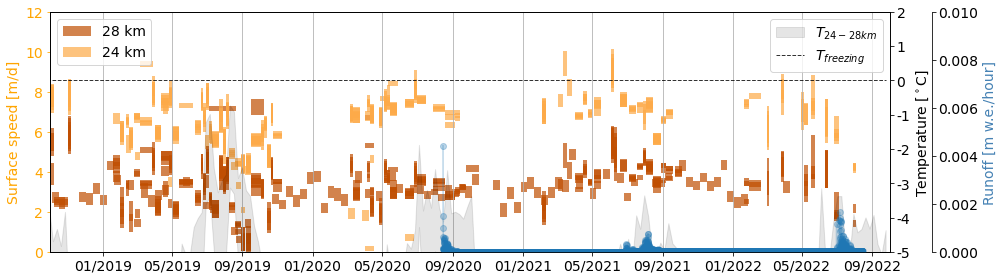

In [100]:
# Plot upper icefall speeds
LAPSE_RATE = -6 # degrees C/K per km
ELEV_HIGH = 2234
ELEV_LOW = 1834
ELEV_MEAN = 2122
YEAR_RANGE = '2019-2022'
WXCOLOR='black'
fs = 14
#######

fig, ax3 = plt.subplots(1,figsize=(14,4))
wx_ax = ax3.twinx() # make twinx with weather

for idx, row in df.iterrows():
    # grab date
    date1 = datetime.datetime.strptime(str(row.ds1),'%Y%m%d')
    date2 = datetime.datetime.strptime(str(row.ds2),'%Y%m%d')
    mid_date = date1+(date2-date1)/2
    halfwidth = date2-mid_date # need halfwidth of dt for patch plotting
    
    # create the patch
    pw = halfwidth*2 # width 
    ph = row.err_v*2 # height
    if ph < 0.25: # make minimum 0.25 height so we can see them
        ph = 0.25
    
    # plot patches and points by each region subplot
    ms = 1 # markersize for all points
    a = 0.7 # alpha value for all patches
     
    # 1) above icefall - orange   
    p24 = patches.Rectangle((date1, row.s24/365-speed_err),pw,ph,facecolor='#fdaa48', alpha=a) # light orange
    p28 = patches.Rectangle((date1, row.s28/365-speed_err),pw,ph,facecolor='#c04e01',alpha=a) # burnt orange
    ax3.add_patch(p28); ax3.add_patch(p24);  
    
# PLOT WEATHER:
temps_high = F_to_C(weekly_df['Temp-AVG'])+(ELEV_LOW/1000)*LAPSE_RATE 
temps_mean = F_to_C(weekly_df['Temp-AVG'])+(ELEV_MEAN/1000)*LAPSE_RATE
temps_low = F_to_C(weekly_df['Temp-AVG'])+(ELEV_HIGH/1000)*LAPSE_RATE 
plt.fill_between(weekly_df.index, temps_low, temps_high, color=WXCOLOR, alpha=0.1)
wx_ax.plot([weekly_df.index[0], weekly_df.index[-1]], [0,0],'--', lw=1,color=WXCOLOR,alpha=0.8)
# wx_ax.plot(weekly_df.index, temps_mean, lw=2,color=WXCOLOR,alpha=0.8)

# TICKMARKS AND PLOT LIMITS
ax3.tick_params(axis='both', labelsize=fs); 
ax3.tick_params(axis='y', labelcolor='orange', color='orange')
ax3.grid(axis='x')
ax3.set_ylabel('Surface speed [m/d]',fontsize=fs,color='orange')
ax3.legend(['28 km','24 km'], ncol=1, loc='upper left', fontsize=fs)

wx_ax.tick_params(axis='y', labelsize=fs, labelcolor='black', color='black', labelbottom=False)
wx_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
wx_ax.set_ylabel('Temperature [$^\circ$C]', fontsize=fs, color='black')
wx_ax.set_ylim(-5,2)
wx_ax.legend(['$T_{24-28km}$','$T_{freezing}$'],loc='upper right', fontsize=fs)

# add spine
twin2 = ax3.twinx()
twin2.spines.right.set_position(("axes", 1.05))
twin2.plot(runoff_df.time, runoff_df.km24/3, 'o-', alpha=0.3)
twin2.set_ylim(0, 0.01)
twin2.tick_params(labelsize=fs)
twin2.set_ylabel('Runoff [m w.e./hour]', fontsize=fs, color='steelblue')

# whole plot:
# x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%Y"))
if YEAR_RANGE == '2019-2022':
    ax3.set_xticks([datetime.datetime(2018,9,1),
                datetime.datetime(2019,1,1),datetime.datetime(2019,5,1), datetime.datetime(2019,9,1),
                datetime.datetime(2020,1,1),datetime.datetime(2020,5,1), datetime.datetime(2020,9,1),
                datetime.datetime(2021,1,1),datetime.datetime(2021,5,1), datetime.datetime(2021,9,1),
                datetime.datetime(2022,1,1),datetime.datetime(2022,5,1), datetime.datetime(2022,9,1),
                   ])
    ax3.set_ylim(0,12)
    ax3.set_xlim(datetime.datetime(2018,10,1), datetime.datetime(2022,10,1))
elif YEAR_RANGE == '2015-2018':
    ax3.set_xticks([
                datetime.datetime(2014,1,1),datetime.datetime(2014,5,1), datetime.datetime(2014,9,1),
                datetime.datetime(2015,1,1),datetime.datetime(2015,5,1), datetime.datetime(2015,9,1),
                datetime.datetime(2016,1,1),datetime.datetime(2016,5,1), datetime.datetime(2016,9,1),
                datetime.datetime(2017,1,1),datetime.datetime(2017,5,1), datetime.datetime(2017,9,1),
                datetime.datetime(2018,1,1),datetime.datetime(2018,5,1),
                   ])
    ax3.set_xlim(datetime.datetime(2014,10,1), datetime.datetime(2018,10,1))
    ax3.set_ylim(0,12)

# labels and layout
background_col='xkcd:white'
# plt.text(-0.055, 1.2, 'b)',fontsize=fs+4,transform = ax.transAxes) # top left label
ax3.set_facecolor(background_col)
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout() 
# plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speed_timeseries_reserviorzoneS1_wx_new.png',dpi=300)
plt.show()

In [102]:
# # peak speed in the reservior zone each year
# year1 = '2018'
# year2 = str(int(year1)+1)
# y1 = int(year1+'0901')
# y2 = int(year2+'0901')
# fall_end = int(year2+'0101')
# # background 

# # grab that year's data
# year_df = df[(df.ds1 > y1) & (df.ds2 < y2) & (df.s9/365 <= 25) & (df.s15/365 <= 25) & (df.s18/365 <= 25)]
# fall_df = df[(df.ds1 > y1) & (df.ds2 < fall_end) & (df.s9/365 <= 25) & (df.s15/365 <= 25) & (df.s18/365 <= 25)]

# # plot
# dates = pd.to_datetime(year_df.ds1, format='%Y%m%d')
# plt.plot(dates, year_df.s9/365, 'o'); plt.plot(dates, year_df.s15/365, 'o'); plt.plot(dates, year_df.s18/365, 'o'); 

# # fall_df = 
# peak_speed = np.nanmax([year_df.s9, year_df.s15, year_df.s18])/365
# if len(fall_df) == 0: # no fall data, use all data
#     mean_speed = np.nanmean([year_df.s9, year_df.s15, year_df.s18])/365
#     print('No fall data')
# else:
#     mean_speed = np.nanmean([fall_df.s9, fall_df.s15, fall_df.s18])/365
# # mean_speed = np.nanmean([df.s9, df.s15, df.s18])/365
# print(peak_speed, mean_speed)
# print(peak_speed/mean_speed)
# plt.plot([np.nanmin(dates), np.nanmax(dates)], [peak_speed, peak_speed], 'k-')
# plt.plot([np.nanmin(dates), np.nanmax(dates)], [mean_speed, mean_speed], 'r-')
# plt.xlim(datetime.datetime(int(year1), 9, 1), datetime.datetime(int(year2), 9, 1))
# plt.title(year1+' to '+year2)
# plt.show()

In [103]:
# # WINTER SUBSETS
# fig, ax3 = plt.subplots(1,figsize=(5,3))
# fs = 14
# wx_ax = ax3.twinx() # make twinx with weather

# for idx, row in df.iterrows():
#     # grab date
#     date1 = datetime.datetime.strptime(str(row.ds1),'%Y%m%d')
#     date2 = datetime.datetime.strptime(str(row.ds2),'%Y%m%d')
#     mid_date = date1+(date2-date1)/2
#     halfwidth = date2-mid_date # need halfwidth of dt for patch plotting
    
#     # create the patch
#     pw = halfwidth*2 # width 
#     ph = row.err_v*2 # height
#     if ph < 0.25: # make minimum 0.25 height so we can see them
#         ph = 0.25
    
#     # plot patches and points by each region subplot
#     ms = 1 # markersize for all points
#     a = 0.9 # alpha value for all patches
     
#     # 3) reservior zone (north) - purple
#     p9 = patches.Rectangle((date1, row.s9/365-row.err_v),pw,ph,facecolor='#b790d4', alpha=a) # pale purple
#     p15 = patches.Rectangle((date1, row.s15/365-row.err_v),pw,ph,facecolor='purple',alpha=a) # purple
#     p18 = patches.Rectangle((date1, row.s18/365-row.err_v),pw,ph,facecolor='#380835',alpha=a) # egg plant
#     ax3.add_patch(p18); ax3.add_patch(p15); ax3.add_patch(p9); 
    
# # PLOT WEATHER:
# # wx_ax.plot(weather_df.date, F_to_C(weather_df['Temp-AVG']), color='red',alpha=0.2)
# wx_ax.plot(weekly_df.index, F_to_C(weekly_df['Temp-AVG']), lw=2, color='white',alpha=0.8)

# # TICKMARKS AND PLOT LIMITS
# ax3.tick_params(axis='both', labelsize=fs); 
# ax3.tick_params(axis='y', labelcolor='purple', color='purple',labelsize=fs); 
# ax3.grid(axis='x')
# ax3.set_ylabel('Surface speed [m/d]',fontsize=fs,color='purple')
# # ax3.legend(['18 km','15 km', '9 km'], loc='upper left', fontsize=fs-2)
# ax3.set_yticks([0,5,10,15,20,25])
# ax3.set_ylim(0,25)


# wx_ax.tick_params(axis='y', labelsize=fs, labelcolor='black', color='black',labelbottom=False)
# wx_ax.set_ylabel('Temperature [$^\circ$C]', fontsize=fs, color='black')
# wx_ax.set_ylim(0,10)

# # whole plot:
# # x-axis
# y1 = 2019
# y2 = 2020
# plt.title(str(y1)+'-'+str(y2), fontsize=fs)
# ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
# ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
# ax3.set_xticks([
#             datetime.datetime(y1,8,1),
#             datetime.datetime(y1,11,1),
#             datetime.datetime(y2,1,1),
#             datetime.datetime(y2,3,1),
#             datetime.datetime(y2,5,1),
#             datetime.datetime(y2,7,1),
#             datetime.datetime(y2,9,1),
#                ])
# ax3.set_xlim(datetime.datetime(y1,10,1), datetime.datetime(y2,10,1))
# # ax3.set_xlim(datetime.datetime(2013,1,1), datetime.datetime(2023,1,1))

# # labels and layout
# background_col='xkcd:light grey'
# ax3.set_facecolor(background_col)
# # fig.supylabel('Surface speed [m/d]', fontsize=fs+2)
# plt.subplots_adjust(wspace=0.1, hspace=0)
# fig.tight_layout() 
# plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speed_timeseries_wx_'+str(y1)+'-'+str(y2)+'.png',dpi=300)
# plt.show()